In [3]:
import pandas as pd
import re

def extract_negative_subsequences(full_sequence, positive_subseq):
    negative_subseq = []
    last_end_position = 0
    
    for start, end in positive_subseq:
        if start > last_end_position + 1:
            neg_start, neg_end = last_end_position + 1, start - 1
            neg_seq = full_sequence[neg_start-1:neg_end]
            if len(neg_seq) == 0:
                print(f"Zero-length negative subsequence detected between {neg_start} and {neg_end}")
            negative_subseq.append((neg_start, neg_end, neg_seq))
        last_end_position = max(last_end_position, end)
    
    if last_end_position < len(full_sequence):
        neg_start, neg_end = last_end_position + 1, len(full_sequence)
        neg_seq = full_sequence[neg_start-1:neg_end]
        negative_subseq.append((neg_start, neg_end, neg_seq))
    
    return negative_subseq

In [2]:
dataset = pd.read_csv('secondary_structures.csv')
dataset

,PDB,Method,Resolution,Sequence,Secondary Structure Type,Positions
0,101M,X-RAY DIFFRACTION,2.07,EGEWQLVLHVWAKV,H,"(4, 17)"
1,101M,X-RAY DIFFRACTION,2.07,EAD,G,"(18, 20)"
2,101M,X-RAY DIFFRACTION,2.07,VAGHGQDILIRLFKS,H,"(21, 35)"
3,101M,X-RAY DIFFRACTION,2.07,PETLEK,G,"(37, 42)"
4,101M,X-RAY DIFFRACTION,2.07,DRVKH,T,"(44, 48)"
...,...,...,...,...,...,...
293,108L,X-RAY DIFFRACTION,1.80,RWYNQ,H,"(137, 141)"
294,108L,X-RAY DIFFRACTION,1.80,T,S,"(142, 142)"
295,108L,X-RAY DIFFRACTION,1.80,PNRAKRVITTFRT,H,"(143, 155)"
296,108L,X-RAY DIFFRACTION,1.80,GTW,S,"(156, 158)"


In [4]:
# Parse positions

dataset[['Start position', 'End position']] = (dataset['Positions'].str.extract(r'\((\d+), (\d+)\)').astype(int))
dataset.drop(columns='Positions', inplace=True)
dataset

,PDB,Method,Resolution,Sequence,Secondary Structure Type,Start position,End position
0,101M,X-RAY DIFFRACTION,2.07,EGEWQLVLHVWAKV,H,4,17
1,101M,X-RAY DIFFRACTION,2.07,EAD,G,18,20
2,101M,X-RAY DIFFRACTION,2.07,VAGHGQDILIRLFKS,H,21,35
3,101M,X-RAY DIFFRACTION,2.07,PETLEK,G,37,42
4,101M,X-RAY DIFFRACTION,2.07,DRVKH,T,44,48
...,...,...,...,...,...,...,...
293,108L,X-RAY DIFFRACTION,1.80,RWYNQ,H,137,141
294,108L,X-RAY DIFFRACTION,1.80,T,S,142,142
295,108L,X-RAY DIFFRACTION,1.80,PNRAKRVITTFRT,H,143,155
296,108L,X-RAY DIFFRACTION,1.80,GTW,S,156,158


In [22]:
total_structure_length = (dataset['End_position'] - dataset['Start_position'] + 1).groupby(dataset['PDB']).sum()
total_protein_length = data[data['Entry'].isin(positive_df['Entry'])].groupby('Entry')['Sequence'].first().apply(len)
structure_percentage = (round(total_structure_length / total_protein_length * 100)).reset_index(name='Structure_Percentage')

negative_df = pd.merge(negative_df, structure_percentage, on='Entry', how='left') if 'Structure_Percentage' not in negative_df.columns else negative_df

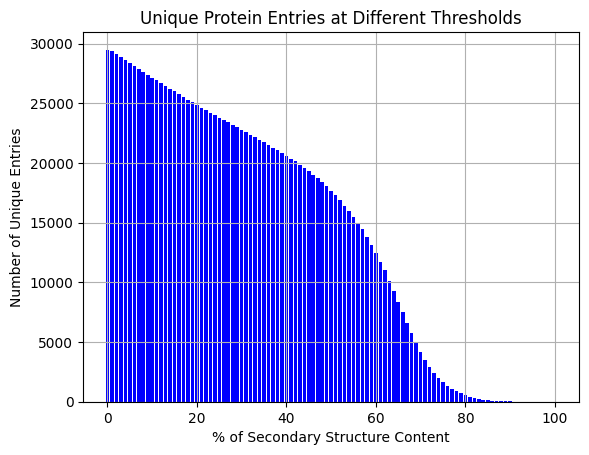

In [23]:
import matplotlib.pyplot as plt

threshold_dfs = {}

thresholds = range(0, 101)
unique_entries = []

for threshold in thresholds:
    threshold_dfs[threshold] = negative_df[negative_df['Structure_Percentage'] >= threshold]
    unique_entries.append(threshold_dfs[threshold]['Entry'].nunique())

thresholds = list(thresholds)

plt.bar(thresholds, unique_entries, color='blue')
plt.xlabel('% of Secondary Structure Content')
plt.ylabel('Number of Unique Entries')
plt.title('Unique Protein Entries at Different Thresholds')
plt.grid(True)
plt.show()

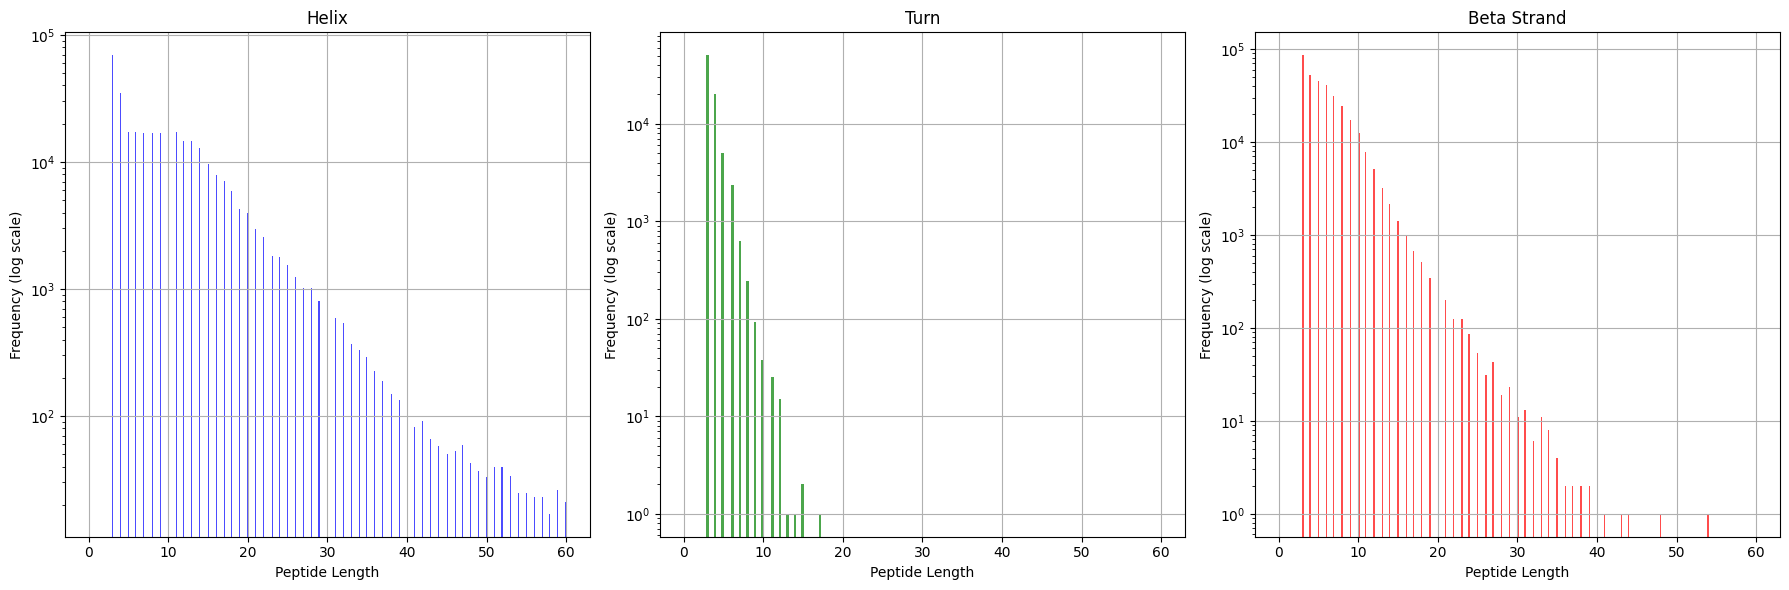

In [24]:
def calculate_bin_width(lengths):
    R = lengths.max() - lengths.min()
    n = len(lengths)
    std = lengths.std()
    return int((R * (n ** (1/3))) / (3.49 * std))

helix_lengths = positive_df[positive_df['Type'] == 'Helix']['Sequence'].apply(len)
turn_lengths = positive_df[positive_df['Type'] == 'Turn']['Sequence'].apply(len)
beta_strand_lengths = positive_df[positive_df['Type'] == 'Beta strand']['Sequence'].apply(len)

bin_width_helix = calculate_bin_width(helix_lengths)
bin_width_turn = calculate_bin_width(turn_lengths)
bin_width_beta_strand = calculate_bin_width(beta_strand_lengths)

plt.figure(figsize=(18, 6))

# Histogram for Helix
plt.subplot(1, 3, 1)
plt.hist(helix_lengths, bins=bin_width_helix, range=(0, 60), color='blue', alpha=0.7, log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Helix')
plt.grid(True)

# Histogram for Turn
plt.subplot(1, 3, 2)
plt.hist(turn_lengths, bins=bin_width_turn, range=(0, 60), color='green', alpha=0.7, log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Turn')
plt.grid(True)

# Histogram for Beta Strand
plt.subplot(1, 3, 3)
plt.hist(beta_strand_lengths, bins=bin_width_beta_strand, range=(0, 60), color='red', alpha=0.7, log=True)
plt.xlabel('Peptide Length')
plt.ylabel('Frequency (log scale)')
plt.title('Beta Strand')
plt.grid(True)

plt.tight_layout()
plt.show()

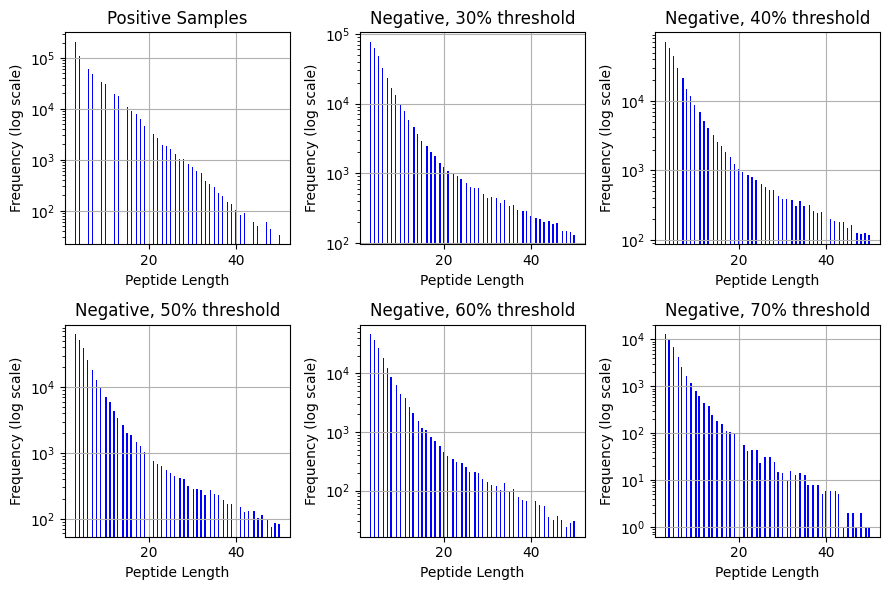

In [25]:
positive_lengths = positive_df[(positive_df['Sequence'].str.len() >= 3) & (positive_df['Sequence'].str.len() <= 50)]['Sequence'].apply(len)
negative_30_lengths = negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 30)]['Sequence'].apply(len)
negative_40_lengths = negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 40)]['Sequence'].apply(len)
negative_50_lengths = negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 50)]['Sequence'].apply(len)
negative_60_lengths = negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 60)]['Sequence'].apply(len)
negative_70_lengths = negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 70)]['Sequence'].apply(len)

bin_positive = calculate_bin_width(positive_lengths)
bin_30_negative = calculate_bin_width(negative_30_lengths)
bin_40_negative = calculate_bin_width(negative_40_lengths)
bin_50_negative = calculate_bin_width(negative_50_lengths)
bin_60_negative = calculate_bin_width(negative_60_lengths)
bin_70_negative = calculate_bin_width(negative_70_lengths)

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axes = axes.flatten()

ax = axes[0]
ax.hist(positive_lengths, bins=bin_positive, color='blue', label='Positive', log=True)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Positive Samples')
ax.grid(True)

ax = axes[1]
ax.hist(negative_30_lengths, bins=bin_30_negative, color='blue', label='Negative30', log=True)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Negative, 30% threshold')
ax.grid(True)

ax = axes[2]
ax.hist(negative_40_lengths, bins=bin_40_negative, color='blue', label='Negative40', log=True)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Negative, 40% threshold')
ax.grid(True)

ax = axes[3]
ax.hist(negative_50_lengths, bins=bin_50_negative, color='blue', label='Negative50', log=True)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Negative, 50% threshold')
ax.grid(True)

ax = axes[4]
ax.hist(negative_60_lengths, bins=bin_60_negative, color='blue', label='Negative60', log=True)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Negative, 60% threshold')
ax.grid(True)

ax = axes[5]
ax.hist(negative_70_lengths, bins=bin_70_negative, color='blue', label='Negative70', log=True)
ax.set_xlabel('Peptide Length')
ax.set_ylabel('Frequency (log scale)')
ax.set_title('Negative, 70% threshold')
ax.grid(True)

plt.tight_layout()
plt.show()

In [26]:
positive_df[(positive_df['Sequence'].str.len() >= 3) & (positive_df['Sequence'].str.len() <= 50)].to_csv('./proteins_reviewed_positive.csv', index=False)
negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50)].to_csv('./proteins_reviewed_negative.csv', index=False)
negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 30)].to_csv('./proteins_reviewed_negative_threshold_30.csv', index=False)
negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 40)].to_csv('./proteins_reviewed_negative_threshold_40.csv', index=False)
negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 50)].to_csv('./proteins_reviewed_negative_threshold_50.csv', index=False)
negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 60)].to_csv('./proteins_reviewed_negative_threshold_60.csv', index=False)
negative_df[(negative_df['Sequence'].str.len() >= 3) & (negative_df['Sequence'].str.len() <= 50) & (negative_df['Structure_Percentage'] >= 70)].to_csv('./proteins_reviewed_negative_threshold_70.csv', index=False)